# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_2760.csv')
df.head(10)

,content,sentimen
0,calon presiden capres anies baswedan menyinggu...,negatif
1,warga kecamatan tanjung bintang kabupaten lamp...,negatif
2,mobil berpelat nomor kedutaan negeri dilaporka...,negatif
3,majelis kehormatan mk memutuskan anwar usman d...,negatif
4,2 motor ruang publik terpadu ramah anak rptra ...,negatif
5,ketua fraksi demokrat dpr ri edhie baskoro yud...,negatif
6,dinas pemadam kebakaran penyelamatan kota depo...,negatif
7,calon presiden bacapres ganjar pranowo menangg...,negatif
8,ketua tim hukum nasional amin ari yusuf menyes...,negatif
9,kanit reskrim polsek pesanggrahan iptu adit ke...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 140468
Jumlah fitur Bag of Words: 18889
Jumlah fitur gabungan: 159357


### Model Naiye Bayes

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Tanpa Parameter

In [11]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)




In [12]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 80.80%
F1 Score: 80.59%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.80      0.82       272
      netral       0.88      0.69      0.77       280
     positif       0.74      0.94      0.83       276

    accuracy                           0.81       828
   macro avg       0.82      0.81      0.81       828
weighted avg       0.82      0.81      0.81       828

Confusion Matrix:
 [[218  18  36]
 [ 32 192  56]
 [  8   9 259]]


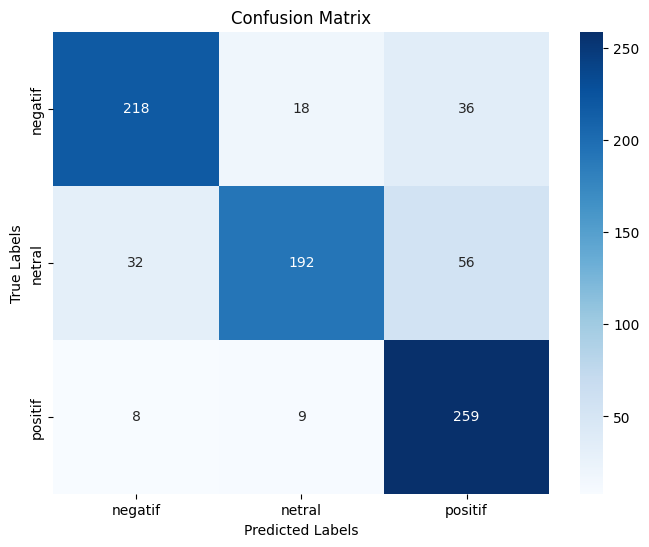

In [13]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Tuning GridCV

In [14]:
# # Define the parameter grid
# param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# # Initialize GridSearchCV
# grid_search = GridSearchCV(model_naiye_tanpa_parameter, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(count_train_features, y_train_encoded)

# # Get the best parameter
# best_alpha = grid_search.best_params_['alpha']
# print("Best alpha:", best_alpha)

# # Get the best model
# best_model = grid_search.best_estimator_
# print("Best alpha:", best_model)

Best alpha: 0.1
Best alpha: MultinomialNB(alpha=0.1)


#### Pakai Paramater

In [15]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha=0.1,fit_prior=True)


# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [16]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 82.37%
F1 Score: 82.17%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.84      0.84       272
      netral       0.89      0.70      0.79       280
     positif       0.76      0.93      0.84       276

    accuracy                           0.82       828
   macro avg       0.83      0.82      0.82       828
weighted avg       0.83      0.82      0.82       828

Confusion Matrix:
 [[229  14  29]
 [ 33 196  51]
 [ 10   9 257]]


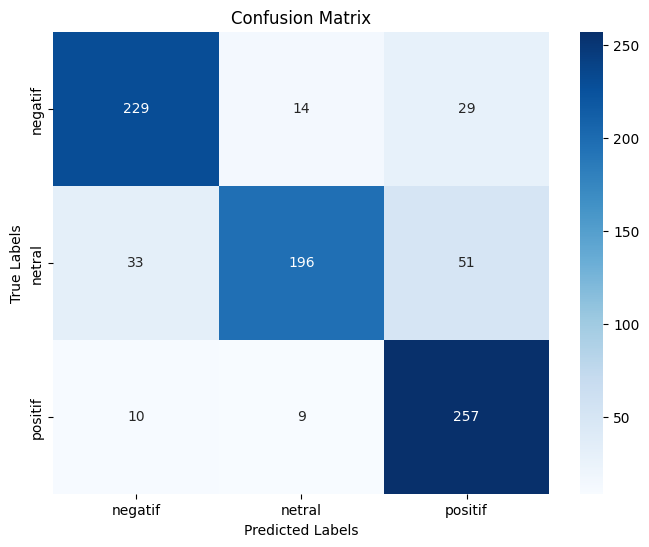

In [17]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Paramater

In [19]:
# Initialize Naive Bayes classifier
svm_tanpa_parameter = SVC(kernel='linear', random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

In [20]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 88.77%
F1 Score: 88.77%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.89      0.85      0.87       272
      netral       0.84      0.94      0.89       280
     positif       0.94      0.87      0.90       276

    accuracy                           0.89       828
   macro avg       0.89      0.89      0.89       828
weighted avg       0.89      0.89      0.89       828

Confusion Matrix:
 [[230  34   8]
 [  8 264   8]
 [ 20  15 241]]


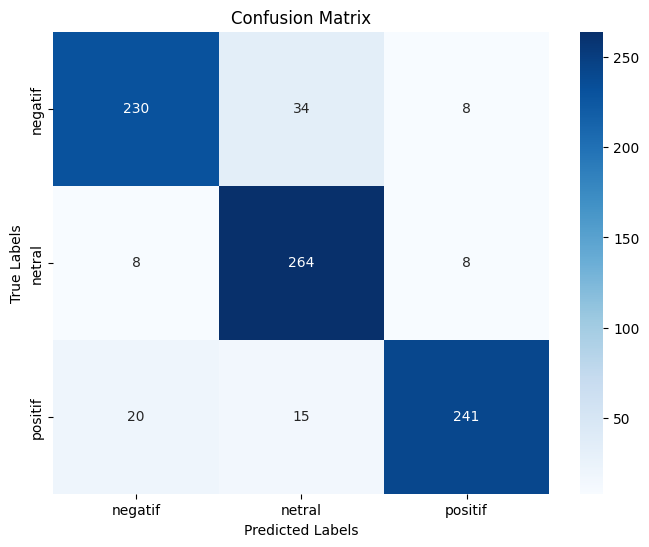

In [21]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Tuning

In [22]:
# # Define the parameter grid
# param_grid_svm = {'C': [0.1, 1, 10],
#                   'gamma': [0.1, 0.01, 0.001],
#                   'kernel': ['linear', 'rbf', 'sigmoid']}

# # Initialize GridSearchCV
# grid_search_svm = GridSearchCV(svm_tanpa_parameter, param_grid_svm, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_svm.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_svm = grid_search_svm.best_params_
# print("Best Parameters:", best_params_svm)

# # Get the best model
# best_model_svm = grid_search_svm.best_estimator_
# print("Best Parameters:", best_params_svm)

Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


#### Pakai Parameter

In [24]:
# Initialize Naive Bayes classifier
svm_parameter = SVC(C=10,gamma=0.001,kernel='sigmoid', random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [25]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 90.34%
F1 Score: 90.35%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.93      0.85      0.89       272
      netral       0.84      0.96      0.90       280
     positif       0.95      0.90      0.93       276

    accuracy                           0.90       828
   macro avg       0.91      0.90      0.90       828
weighted avg       0.91      0.90      0.90       828

Confusion Matrix:
 [[230  35   7]
 [  5 269   6]
 [ 11  16 249]]


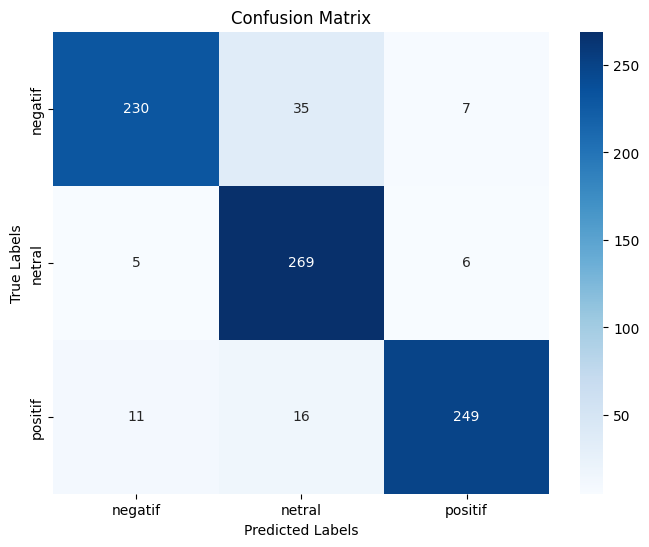

In [26]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Paramater

In [32]:
# Initialize Naive Bayes classifier
lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [33]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 90.82%
F1 Score: 90.82%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.94      0.87      0.90       272
      netral       0.87      0.95      0.91       280
     positif       0.93      0.91      0.92       276

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828

Confusion Matrix:
 [[236  27   9]
 [  4 266  10]
 [ 12  14 250]]


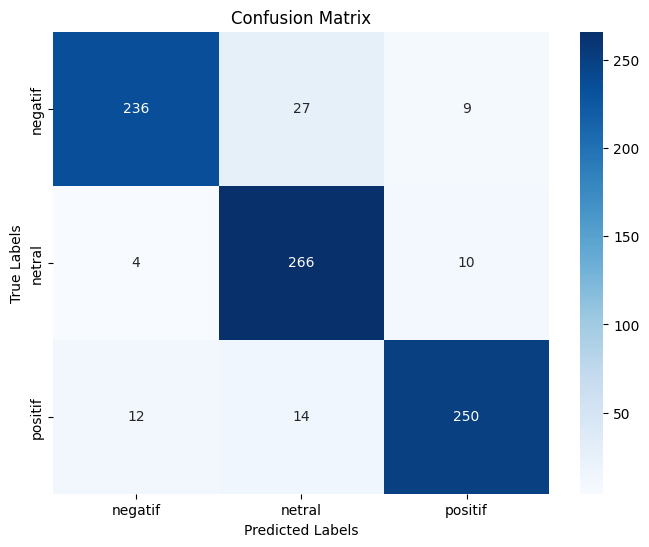

In [34]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Tuning

In [37]:
# # Define the parameter grid
# param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10],
#                  'penalty': ['l1', 'l2'], 
#                   'solver': ['liblinear', 'saga'],
#                   'max_iter': [1000]
#                  }

# # Initialize GridSearchCV
# grid_search_lr = GridSearchCV(lr_tanpa_parameter, param_grid_lr, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_lr.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_lr = grid_search_lr.best_params_
# print("Best Parameters:", best_params_lr)

# # Get the best model
# best_model_lr = grid_search_lr.best_estimator_
# print("Best Parameters:", best_params_lr)


/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}


/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Parameter

In [38]:
# Initialize Naive Bayes classifier
lr_parameter =  LogisticRegression(C=0.1,penalty="l2",random_state=42,max_iter=1000,solver='sag')

## Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [39]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 91.06%
F1 Score: 91.06%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.94      0.87      0.90       272
      netral       0.87      0.95      0.91       280
     positif       0.93      0.91      0.92       276

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828

Confusion Matrix:
 [[236  26  10]
 [  5 267   8]
 [ 10  15 251]]


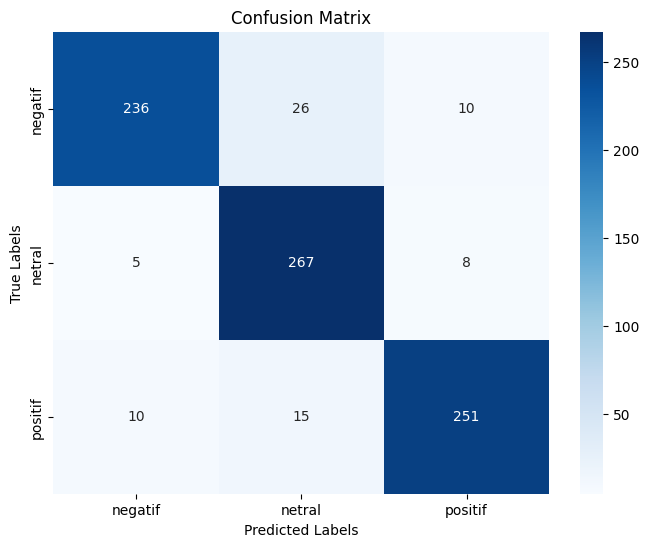

In [40]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Paramater

In [43]:
# Initialize Naive Bayes classifier
rfc_tanpa_parameter = RandomForestClassifier(random_state=42)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(rfc_tanpa_parameter, count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [44]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.20%
F1 Score: 87.04%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.90      0.76      0.83       272
      netral       0.86      0.94      0.90       280
     positif       0.86      0.91      0.89       276

    accuracy                           0.87       828
   macro avg       0.87      0.87      0.87       828
weighted avg       0.87      0.87      0.87       828

Confusion Matrix:
 [[208  31  33]
 [ 10 263   7]
 [ 12  13 251]]


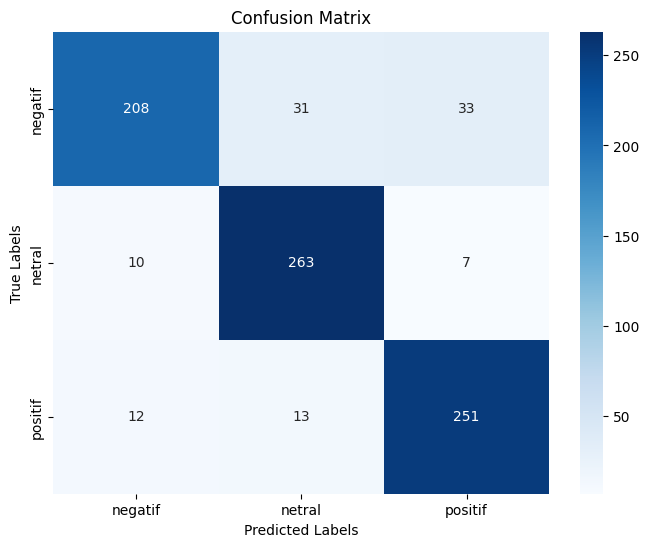

In [34]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Tuning

In [45]:
# # Define the parameter grid
# param_grid_rfc = {'n_estimators': [50, 100, 200],
#                   'max_depth': [None, 10, 20, 30],
#                   'min_samples_split': [2, 5, 10]}

# # Initialize GridSearchCV
# grid_search_rfc = GridSearchCV(rfc_tanpa_parameter, param_grid_rfc, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search_rfc.fit(count_train_features, y_train_encoded)

# # Get the best parameters
# best_params_rfc = grid_search_rfc.best_params_
# print("Best Parameters:", best_params_rfc)

# # Get the best model
# best_model_rfc = grid_search_rfc.best_estimator_
# print("Best Parameters:", best_model_rfc)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Parameters: RandomForestClassifier(random_state=42)


#### Paramater

In [46]:
# Initialize Naive Bayes classifier
rfc_parameter = RandomForestClassifier(min_samples_split=2,n_estimators=100)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(rfc_tanpa_parameter, count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [47]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 87.20%
F1 Score: 87.04%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.90      0.76      0.83       272
      netral       0.86      0.94      0.90       280
     positif       0.86      0.91      0.89       276

    accuracy                           0.87       828
   macro avg       0.87      0.87      0.87       828
weighted avg       0.87      0.87      0.87       828

Confusion Matrix:
 [[208  31  33]
 [ 10 263   7]
 [ 12  13 251]]


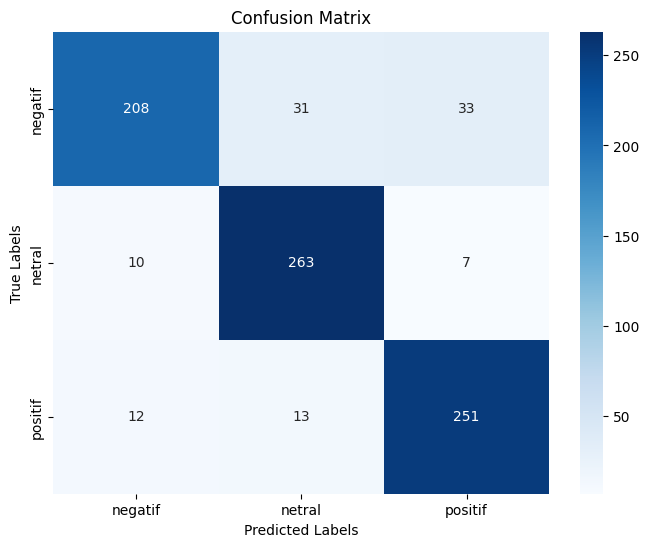

In [48]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

### Model Ensemble Learning

In [49]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = svm_parameter
best_model_random_forest = rfc_parameter
best_model_logistic_regression = lr_parameter

In [50]:
from sklearn.ensemble import VotingClassifier

#### Model Gabungin 4 Model

In [51]:
# Membuat model ensemble
ensemble_model_4 = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_4, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 92.03%
F1 Score: 92.03%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.95      0.89      0.92       272
      netral       0.87      0.97      0.92       280
     positif       0.95      0.90      0.93       276

    accuracy                           0.92       828
   macro avg       0.92      0.92      0.92       828
weighted avg       0.92      0.92      0.92       828

Confusion Matrix:
 [[241  21  10]
 [  5 272   3]
 [  8  19 249]]


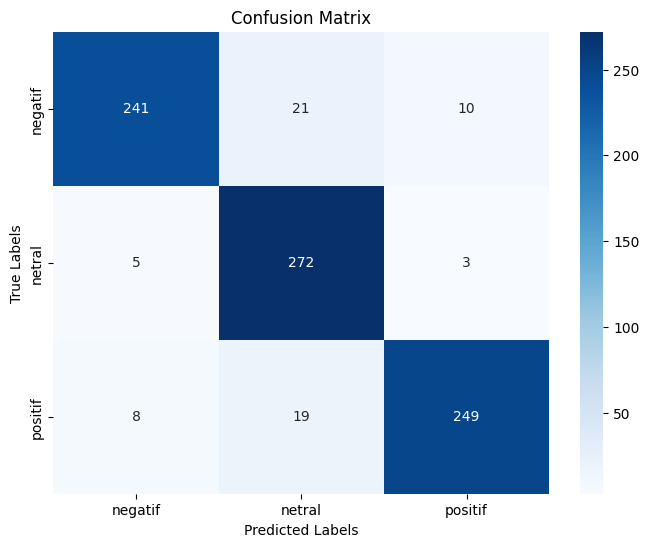

In [53]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Model 3 dengan Akurasi Terbaik

In [54]:
# Membuat model ensemble
ensemble_model_3 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_3, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [55]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 91.06%
F1 Score: 91.07%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.94      0.86      0.90       272
      netral       0.86      0.96      0.91       280
     positif       0.94      0.91      0.93       276

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828

Confusion Matrix:
 [[234  29   9]
 [  5 269   6]
 [  9  16 251]]


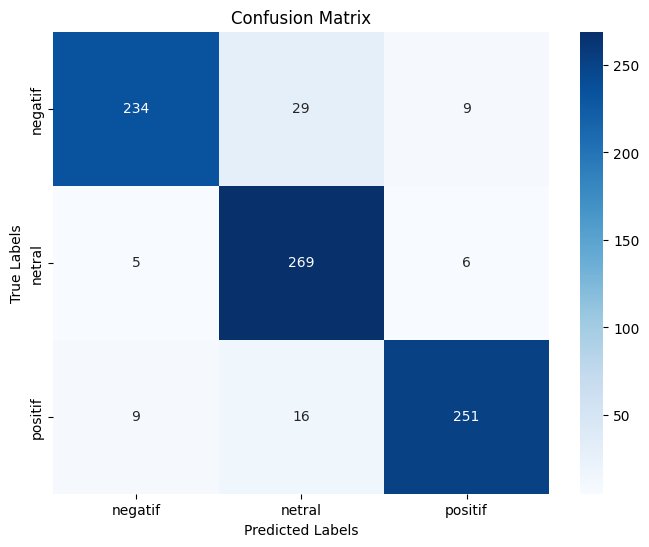

In [56]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

#### Model 2 Dengan Nilai Akurasi Terbaik 

In [57]:
# Membuat model ensemble
ensemble_model_2 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(ensemble_model_2, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

/home/krisna/ProjectTA/model_ta/env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [58]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 90.82%
F1 Score: 90.84%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.92      0.88      0.90       272
      netral       0.86      0.96      0.90       280
     positif       0.96      0.89      0.92       276

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828

Confusion Matrix:
 [[239  27   6]
 [  8 268   4]
 [ 13  18 245]]


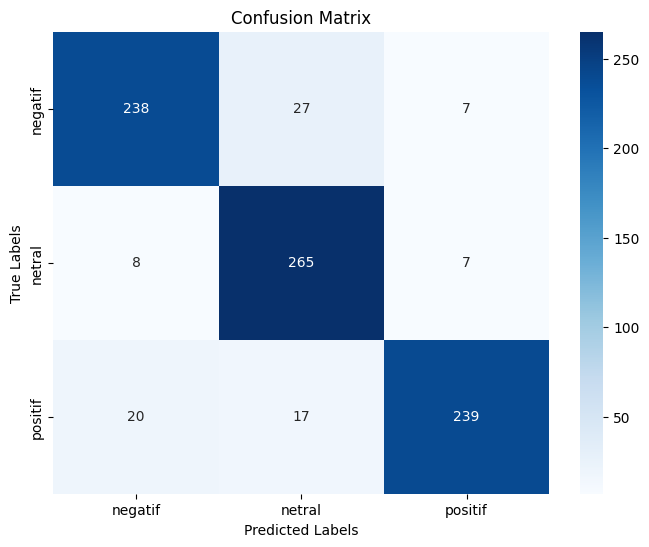

In [48]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)